In [1]:

from scipy.interpolate import UnivariateSpline
import scipy.integrate as integrate
import numpy as np
import scipy
from scipy import stats
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
from  scipy.integrate import * 
jtplot.style(theme="grade3", context="notebook", ticks=True, grid=False)
import pickle
#import solver related modules
from MCEq.core import MCEqRun
import mceq_config as config
#import primary model choices
import crflux.models as pm



In [2]:
atmosphere = ('CORSIKA', ("Karlsruhe", None))
mceq_run = MCEqRun(
        interaction_model='SIBYLL2.3c',
        primary_model=(pm.HillasGaisser2012,'H4a'),
        theta_deg=0,
    )
mceq_run.set_density_model(atmosphere)


#Power of energy to scale the flux (the results will be returned as E**mag * flux)
mag = 0

#obtain energy grid (fixed) of the solution for the x-axis of the plots
e_grid = mceq_run.e_grid

#Dictionary for results
flux = {}
#theta 
theta=[0]
numu_conv={}
numu_pr={}
nue_conv={}
nue_pr={}
nutau_conv={}
nutau_pr={}


MCEqRun::set_interaction_model(): SIBYLL23C
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
MCEqRun::set_primary_model(): HillasGaisser2012 H4a
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('Karlsruhe', None)


In [3]:
#Galactic centre -----------------
sigma_nu_theo= 10**(-23) # cm^3/s   thermally averaged cross section to neutrinos 300 GeV to 3 TeV from Fermi-LAT and HESS 
sigma_nu1=5* 10**(-26) # 1 MeV/c^2
sigma_nu2=10**(-17) # 10^11 GeV/c^2
Kappa_m=2 # majorana DM  ----- This is used for the paper--------
Kappa_d=4 # Dirac DM

h=0.674

n=-1.316# power spetcrum index
rho_c_mpc=(2.7754e11)# h^-2 M_0 Mpc^-3-------------> Mpc!!!!!



In [4]:
rho_0=0.4 # GeV cm^-3
R_0= 8.127*10**(-3) # Mparsec (Mpc) --- Gc to Sun -------------!!!!!!!!!!!!!!!!!!!!!!!!
gamma=1.3186 # NFW parameter --- slope parameter -----
rho_m=29.65e12 # M_sun Mpc^-3


In [5]:
#values of  J for P-ONE ------------

#c_zenith_1= [-1,-0.5]
J_s1=0.87e23
J_p1=0.85e17
J_d1=1.4e11


#c_zenith_2= [-0.5,0.5]
J_s2=1.2e23
J_p2=1.2e17
J_d2=2.0e11

#c_zenith_3= [0.5,1]
J_s3=0.13e23
J_p3=0.13e17
J_d3=0.18e11

In [6]:
M=np.logspace(-1,15,400,10)
E=np.logspace(-1,8,100,10)

In [7]:
H_0=71# km/(Mpc*s) hubble time --- 
#rho_s scale density 
r_s=20 # kpc scale radius ----
gamma=1.318 #  change accordingly-------
rho_0=0.4 # GeV cm^(-3) 
R_0=8.127 # kpc
omega_k=-0.09
omega_m=0.27
omega_c=0.2589
omega_DM=0.23
omega_L=0.721 # dark energy density 
omega_B=0.046
omega_re=9.8e-5
rho_B=omega_B*rho_c_mpc# baryonic mass density -------
# radiation density of these the most accurately measured ---------

In [ ]:
m_dm=[1,1e2,1e4,1e6]
k=2
sigma_nu=5e-29

In [8]:
def dN_nu_E_nu(m_x,E):
    if E==m_x:
        return 1/(E) # 3 is for three active neutrino flavours
    else:
        return 0
    
    


In [9]:
def dphi_dE_g(sigma,k,m,E,J):
    return (1/(4*np.pi))*(sigma/(3*k*m**2))*(dN_nu_E_nu(m,E))*J

In [10]:
def dN_nu_E_nu_Extra(m_x,E):#
    if E<=m_x:
        return 1/(3*E) # 3 is for three active neutrino flavours
    else: 
        return 0


In [11]:
J=J_s1+J_p1+J_d1+J_s2+J_s3+J_p2+J_p3+J_d2+J_d3

In [13]:
def R(rho_b,M): # baryon density as per 2008 ZARIJA stdudy-------
    return (3*M/(4*rho_b*np.pi))**(1/3)

In [14]:
# Extra galactic contribution ----------------------------

In [15]:
def a_z(z):
    return 1/(1+z)

In [16]:
def H(a,H_0,Omega_m,Omega_L): # time dependent Hubble parameter 
    
    return ( (Omega_m/a**3) +Omega_L)**(1/2)
    

In [17]:
def D_to_inte(a,H_0,Omega_m,Omega_L):
    return 1/ ( ( a*H(a,H_0,Omega_m,Omega_L) )**3 )

In [18]:
def D(a,H_0,Omega_m,Omega_L):
        return (5 * Omega_m * H(a,H_0,Omega_m,Omega_L) / (2*H_0) 
               ) *( integrate.quad( D_to_inte, 0, a, args=(H_0,Omega_m,Omega_L))[0])
   

In [19]:
def d(a,H_0,Omega_m,Omega_L):
    t=D(a,H_0,Omega_m,Omega_L)
    return t/D(1,H_0,Omega_m,Omega_L)

In [20]:
def omega_mz(z): # I have neglected omega_re and omega_k couldn't find proper values
    return (omega_m * (1+z)**3 ) /(omega_L+(omega_m*(1+z)**3))

In [21]:
def A_z(z):
   return omega_mz(z)*( 0.99*((1+z)**(-3.216)) + 0.074)

In [22]:
def alpha_z(z):
    return    omega_mz(z)*(5.907*((1+z)**(-3.599)) + 2.344)

In [23]:
def beta_z(z):
        return omega_mz(z)*(3.136*((1+z)**(-3.058)) +2.349 )

In [24]:
Z=np.linspace(0,60,60)
D_s=np.vectorize(d)(a_z(Z),H_0,omega_m,omega_L)

In [25]:
#Literature values for comparisons----------- 
dn_dlogM_20=np.loadtxt("z_2.csv",delimiter=",")
dn_dlogM_0=np.loadtxt("z_0.txt",delimiter=",")
dn_dlogM_15=np.loadtxt("z_15.csv",delimiter=",")
dn_dlogM_5=np.loadtxt("z_5.csv",delimiter=",")
dn_dlogM_10=np.loadtxt("z_10.csv",delimiter=",")


In [26]:
def rho_s(R,r_s,g,rho_0):
    """
    rho_s from rho_0 in GeV cm**-3  
    """
    
    r_r=R/r_s 
    return rho_0*(((r_r)**(g))*(1+r_r)**(3-g))/(2**(3-g))

In [27]:
Delta=200 # Lopez et al. ---------- M_min=10e-5------

In [28]:
Rho_s=rho_s(8.127,20,1.28,0.4)

In [30]:
#----------Lopez----------------

In [31]:
def sigma_lopez(M):
    return np.exp((2.6*M**(0.001745))-0.2506*M**0.07536)

In [32]:
def f_178(M,z):
    """
    f_178 from lopez eq b19
    
    
    """
    
    
    
    A=omega_mz(z)*(1.907*(1+z)**(-3.216) + 0.074)
    al=omega_mz(z)*(5.907*(1+z)**(-3.599) + 2.344)
    beta=omega_mz(z)*(3.136*(1+z)**(-3.068) + 2.349)
    gamma=1.318
    
    sigma=sigma_lopez(M)*d(a_z(z),H_0,omega_m,omega_L)
    
    
    return A*(  (sigma/beta)**(-al) + 1    )*np.exp(-gamma/sigma**2)
    

In [33]:
def f_delta(M,z):
    
    """
    f_delta from lopez eq b21
    """
    sigma=sigma_lopez(M)*d(a_z(z),H_0, omega_m, omega_L)
    delta=200
    b_t= np.exp( ((delta/178) -1) * (0.023-(0.072/sigma**2.13) ))* (delta/178)**( (-0.456*omega_mz(z)) - 0.139) 
    return f_178(M,z)*b_t

In [34]:
def g_tild(M,z):
    
    c_0 = 3.681
    c_1 = 5.033
    al = 6.948
    x_0 = 0.424
    s_0 = 1.047
    s_1 = 1.646
    b = 7.386
    x_1 = 0.526

    A = 2.881
    b = 1.257
    c = 1.022
    d_2 = 0.060
    
    D_s= d(a_z(z),H_0,omega_m,omega_L)
    sigma=sigma_lopez(M)*D_s

    x=(1/(1+z))*(omega_L/omega_m)**(1/3)
    def c_min(x):
        return c_0+(c_1-c_0)*(  ( np.arctan(al*(x-x_0)) / np.pi ) + (1/2))
    def s_min(x):
        return s_0+(s_1-s_0)*(  ( np.arctan(b*(x-x_1)) / np.pi ) + (1/2))

    def B_0(x):
        return c_min(x)/c_min(1.393)
    def B_1(x):
        return s_min(x)/s_min(1.393)

    def s_in(x):
        return B_1(x)*sigma
    def C(x):
        aa=(   ((s_in(x)/b)**c)   + 1   )
        dd=np.exp(d_2/s_in(x)**2)
        return A*aa*dd

    def c_200(x):
        return B_1(x)*C(x)
    if c_200(x)>=100:
        a=100
    else:
        a=c_200(x)
    return (a**3)*(1-(1+a)**(-3))/(3*(np.log(1+a)-a*(1+a)**(-1)))**2

In [35]:
def dln_sigma_1(M):
    
    return 0.2506*0.07536*M**(0.07536-1)- 2.6*0.001745*M**(0.001745-1)
    

In [55]:
def G_lopez(z):
    def integrand(M,z):
        return dln_sigma_1(M)*f_delta(M,z)*g_tild(M,z)
    
    aa=((omega_m/omega_DM)**2)*Delta/(3*omega_mz(z))
    
    bb=integrate.quad(integrand,1e-2,1e1,args=(z))[0]+integrate.quad(integrand,1e1,1e10,args=(z))[0]+integrate.quad(integrand,1e10,1e17,args=(z))[0]
     
    return aa*bb
    

In [37]:
def dphide_lopez(E,m_x,snu):
    """
    
    """
    if E<=m_x:
        z=(m_x/E) - 1
        
        a_t=(1+G_lopez(z))*(1+z)**3
        
        b_t=H(a_z(z),H_0,omega_m,omega_L)
        
        a_g=a_t/b_t
        
        aaa=snu*((omega_DM*rho_c_mpc)**2)
        
        b=8*np.pi*m_x**2
        
        return aaa*a_g/(3*E*b)
    else:
        return 0
    

In [38]:
def dphi_astro(E):
    """
    Astrophysical flux because of muon background as per the power law described in new constraints on supersymmetry
    using neutrino telescopes
    """
    return 3*1e-18*1.66*(E/1e5)**(-2.53)

In [39]:
def A_eff():
    """
    A_eff from PONE paper 
    
    returns :
    three tuples for cos(theta)  1 to 0.5 , 0.5 to -0.5 , -0.5 to -1 
    
    """
    A_5_5=np.loadtxt("A_55.csv",delimiter=",")
    A_1_5=np.loadtxt("A_1_5.csv",delimiter=",")
    A1_5=np.loadtxt("A51.csv",delimiter=",")
    A_5_5=(A_5_5[A_5_5[:,0].argsort()])
    A_1_5=(A_1_5[A_1_5[:,0].argsort()])
    A1_5=(A1_5[A1_5[:,0].argsort()])
    A_5_5=np.concatenate((np.array([[100,0]]),A_5_5),axis=0)
    A_1_5=np.concatenate((np.array([[100,0]]),A_1_5),axis=0)
    A1_5=np.concatenate((np.array([[100,0]]),A1_5),axis=0)
    
    A_1_5=UnivariateSpline(A_1_5[:,0],A_1_5[:,1],k=1,s=0,ext=3)
    A1_5=UnivariateSpline(A1_5[:,0],A1_5[:,1],k=1,s=0,ext=3)
    A_5_5=UnivariateSpline(A_5_5[:,0],A_5_5[:,1],k=1,s=0,ext=3)
    return A1_5,A_5_5,A_1_5


In [40]:
"""dphi_1=np.loadtxt("m_1.csv",delimiter=",")
dphi_1e2=np.loadtxt("m_1e2.csv",delimiter=",")
dphi_1e4=np.loadtxt("m_1e4.csv",delimiter=",")
dphi_1e6=np.loadtxt("m_1e6.csv",delimiter=",")
dphi_1e4=(dphi_1e4[dphi_1e4[:,0].argsort()])
dphi_1e6=(dphi_1e6[dphi_1e6[:,0].argsort()])

E[m_dm[0]]=dphi_1e4[:,0]
E[m_dm[1]]=dphi_1e6[:,0]
#E[m_dm[2]]=dphi_1e4[:,0]
#E[m_dm[3]]=dphi_1e6[:,0]"""

'dphi_1=np.loadtxt("m_1.csv",delimiter=",")\ndphi_1e2=np.loadtxt("m_1e2.csv",delimiter=",")\ndphi_1e4=np.loadtxt("m_1e4.csv",delimiter=",")\ndphi_1e6=np.loadtxt("m_1e6.csv",delimiter=",")\ndphi_1e4=(dphi_1e4[dphi_1e4[:,0].argsort()])\ndphi_1e6=(dphi_1e6[dphi_1e6[:,0].argsort()])\n\nE[m_dm[0]]=dphi_1e4[:,0]\nE[m_dm[1]]=dphi_1e6[:,0]\n#E[m_dm[2]]=dphi_1e4[:,0]\n#E[m_dm[3]]=dphi_1e6[:,0]'

In [41]:
for i in theta: #Set the zenith angle
    mceq_run.set_theta_deg(i)
    #Run the solver
    mceq_run.solve()

    numu_conv[i] = (mceq_run.get_solution('conv_numu', mag)
                 + mceq_run.get_solution('conv_antinumu', mag))

    numu_pr[i] = (mceq_run.get_solution('pr_numu', mag)
               + mceq_run.get_solution('pr_antinumu', mag))
    nue_conv[i] = (mceq_run.get_solution('conv_nue', mag)
                 + mceq_run.get_solution('conv_antinue', mag))

    nue_pr[i] = (mceq_run.get_solution('pr_nue', mag)
               + mceq_run.get_solution('pr_antinue', mag))

    nutau_conv[i] = (mceq_run.get_solution('conv_nutau', mag)
                 + mceq_run.get_solution('conv_antinutau', mag))

    nutau_pr[i] = (mceq_run.get_solution('pr_nutau', mag)
               + mceq_run.get_solution('pr_antinutau', mag))


In [64]:
m_dm=np.logspace(3,6,15,10)
snu=np.logspace(-26,-23,15,10)
A_1_5=A_eff()[2](e_grid)
A_5_5=A_eff()[1](e_grid)
A1_5=A_eff()[0](e_grid)
A=(A_5_5*(np.pi/2 - np.pi/3)   + A_1_5*((2*np.pi/3)) + A1_5*(np.pi/2 - np.pi/3))

numu_total=(numu_conv[0]+numu_pr[0]+(1/3)*dphi_astro(mceq_run.e_grid))*mceq_run.e_widths*A*5*60*60*24*365

In [65]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [66]:
def x_stat(m_d,sn):
    #s_lo=np.zeros((sn.shape,m.shape[0]))
    for i,m in enumerate(m_d):
     
        s_lo_t=np.array([])
        s_lo_t_2=np.array([])
        for j,s in enumerate(sn): 
            t_up=find_nearest(mceq_run.e_grid,m+1)
            t_d=find_nearest(mceq_run.e_grid,5e2)
            r=np.vectorize(dphide_lopez)(mceq_run.e_grid[t_d:t_up],m,s)+np.vectorize(dphi_dE_g)(s,2,m,e_grid[t_d:t_up],J)
            
            r=np.nan_to_num(r)
            #print(np.nan_to_num(r))
            #print(numu_total[t_d:t_up])
            
            x=((r*mceq_run.e_widths[t_d:t_up]*A[t_d:t_up]*60*60*24*365*5)**2)/numu_total[t_d:t_up]
            xx=((r*mceq_run.e_widths[t_d:t_up]*A[t_d:t_up]*60*60*24*365*5)**2)/np.sqrt(numu_total[t_d:t_up])

            y=stats.chi2.sf(np.sum(np.nan_to_num(x)),2)
            yy=stats.chi2.sf(np.sum(np.nan_to_num(xx)),2)
            s_lo_t=np.append(s_lo_t,y)
            s_lo_t_2=np.append(s_lo_t_2,yy)
        
        if i==0:
            s_lo=np.array([s_lo_t])
            s_lo_2=np.array([s_lo_t_2])
        else:
            s_lo=np.concatenate((s_lo,np.array([s_lo_t])),axis=0)
            s_lo_2=np.concatenate((s_lo_2,np.array([s_lo_t_2])),axis=0)
    return s_lo,s_lo_2

In [ ]:
%time tmp_res = x_stat(m_dm, snu)

<ipython-input-55-0bd4e5b6d5a3>:7: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  bb=integrate.quad(integrand,1e-2,1e1,args=(z))[0]+integrate.quad(integrand,1e1,1e10,args=(z))[0]+integrate.quad(integrand,1e10,1e17,args=(z))[0]
<ipython-input-34-8ddc7113ccb6>:35: RuntimeWarning: overflow encountered in exp
  dd=np.exp(d_2/s_in(x)**2)
<ipython-input-55-0bd4e5b6d5a3>:7: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  bb=integrate.quad(integrand,1e-2,1e1,args=(z))[0]+integrate.quad(integrand,1e1,1e10,args=(z))[0]+integrate.quad(integrand,1e10,1e17,args=(z))[0]
<ipython-input-34-8ddc7113ccb6>:36: RuntimeWarning: overflow encountered in double_scalars
  return A*aa*dd


In [ ]:
pickle.dump(tmp_res,open('30_06_15.pkl','wb'))

In [ ]:
cl_lit=np.loadtxt('CL_PONE.csv',delimiter=",")
cl_lit=(cl_lit[cl_lit[:,0].argsort()])


In [ ]:
cl=pickle.load(open("30_06_15.pkl","rb"))

<ipython-input-61-ce7209a22b4c>:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(m_dm,snu,1-cl[0].T,cmap=plt.cm.Accent)


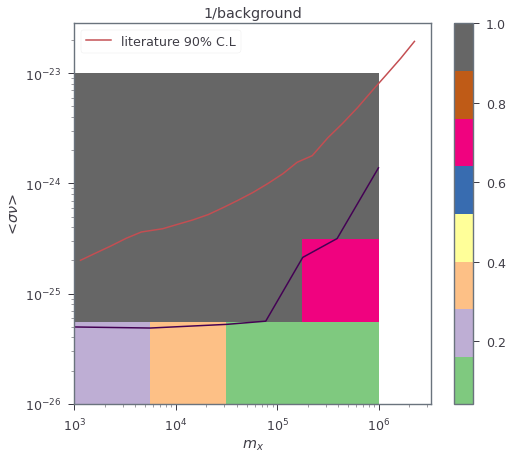

In [61]:
plt.title("1/background")
plt.contour(m_dm,snu,1-cl[0].T,levels=[0.9,1])
#plt.contour(m_dm,snu,1-cl[1].T,levels=[0.9,1])
plt.pcolor(m_dm,snu,1-cl[0].T,cmap=plt.cm.Accent)
plt.plot(cl_lit[:,0],cl_lit[:,1],'r',label='literature 90% C.L')
plt.xscale("log")
plt.yscale("log")
plt.colorbar()
plt.xlabel(r"$m_{x}$")
plt.ylabel(r"<$\sigma \nu$>")
plt.legend()

<ipython-input-62-0d00d01f592b>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(m_dm,snu,1-cl[1].T,cmap=plt.cm.Accent)


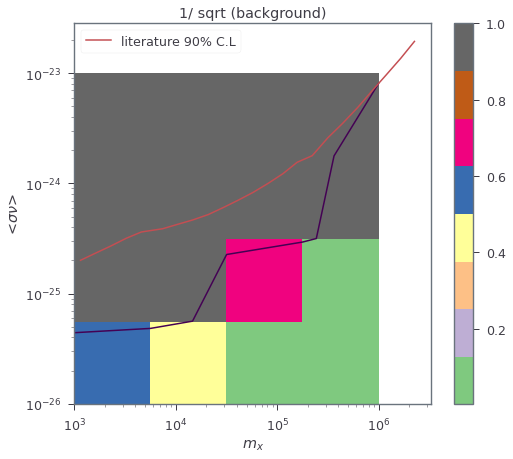

In [62]:
plt.title("1/ sqrt (background)")
plt.contour(m_dm,snu,1-cl[1].T,levels=[0.9,1])
plt.pcolor(m_dm,snu,1-cl[1].T,cmap=plt.cm.Accent)
plt.plot(cl_lit[:,0],cl_lit[:,1],'r',label='literature 90% C.L')
plt.xscale("log")
plt.yscale("log")
plt.colorbar()
plt.xlabel(r"$m_{x}$")
plt.ylabel(r"<$\sigma \nu$>")
plt.legend()

No handles with labels found to put in legend.


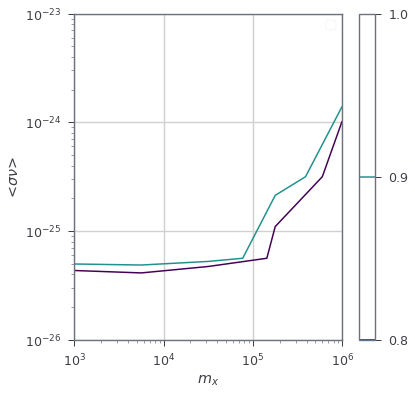

In [63]:
plt.figure(figsize=(6,6))
plt.contour(m_dm,snu,1-cl[0].T,levels=[0.8,0.9,1])
plt.xscale("log")
plt.yscale("log")
plt.colorbar()
plt.legend()
plt.xlabel(r"$m_{x}$")
plt.ylabel(r"<$\sigma \nu$>")
plt.grid()

In [ ]:
A=(A_5_5(mceq_run.e_grid)+A_1_5(mceq_run.e_grid)+A1_5(mceq_run.e_grid))
plt.figure(figsize=(6,6))
plt.title(r"$\nu_{\mu}$ , -1<$cos(\theta)$<1"+r"$<\igma_{nu}>$=$3\times 10^26$")
for j,m in enumerate(m_dm):
    #plt.scatter(E,ddd[m]*(E**2),label='m_x='+'{:e}'.format(m))
    plt.step(e_grid,(s_lo[m])*(A)*60*60*24*365*mceq_run.e_widths,label=r'$m_\chi$='+name[j]+"GeV")

    #plt.step(e_grid,(s_fit[m](e_grid))*(A)*60*60*24*365*mceq_run.e_widths,label=r'spline $m_\chi$='+name[j]+"GeV")
plt.step(e_grid,(numu_conv[theta[0]]+numu_pr[theta[0]])*A*60*60*24*365*mceq_run.e_widths,label='Atmospheric' )
plt.step(e_grid,(1/3)*dphi_astro(e_grid)*(A)*60*60*24*365*mceq_run.e_widths,label='Astrophysical flux')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$E_{\nu}$ [GeV]')
plt.ylabel(r'counts / year')
plt.ylim(1e0,1e5)
plt.xlim(1e2,1e6)
plt.legend()



In [ ]:
plt.figure(figsize=(6,6))
plt.title(r"$\nu_{tau}$ , -1<$cos(\theta)$<1")
for j,m in enumerate(m_dm):
    #plt.scatter(E,ddd[m]*(E**2),label='m_x='+'{:e}'.format(m))
    plt.step(e_grid,(s_lo[m])*(A)*60*60*24*365*mceq_run.e_widths,label=r'$m_\chi$='+name[j]+"GeV")

    #plt.step(e_grid,(s_fit[m](e_grid))*(A)*60*60*24*365*mceq_run.e_widths,label=r'spline $m_\chi$='+name[j]+"GeV")
plt.step(e_grid,(nutau_conv[theta[0]]+nutau_pr[theta[0]])*A*60*60*24*365*mceq_run.e_widths,label='Atmospheric' )
plt.step(e_grid,(1/3)*dphi_astro(e_grid)*(A)*60*60*24*365*mceq_run.e_widths,label='Astrophysical flux')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$E_{\nu}$ [GeV]')
plt.ylabel(r'counts / year')
plt.ylim(1e0,1e4)
plt.xlim(1e2,1e6)
plt.legend()



In [ ]:
plt.figure(figsize=(6,6))
plt.title(r"$\nu_{e}$ , -1<$cos(\theta)$<1")
for j,m in enumerate(m_dm):
    #plt.scatter(E,ddd[m]*(E**2),label='m_x='+'{:e}'.format(m))
    plt.step(e_grid,(s_lo[m])*(A)*60*60*24*365*mceq_run.e_widths,label=r'$m_\chi$='+name[j]+"GeV")

    #plt.step(e_grid,(s_fit[m](e_grid))*(A)*60*60*24*365*mceq_run.e_widths,label=r'spline $m_\chi$='+name[j]+"GeV")
plt.step(e_grid,(nue_conv[theta[0]]+nue_pr[theta[0]])*A*60*60*24*365*mceq_run.e_widths,label='Atmospheric' )
plt.step(e_grid,(1/3)*dphi_astro(e_grid)*(A)*60*60*24*365*mceq_run.e_widths,label='Astrophysical flux')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$E_{\nu}$ [GeV]')
plt.ylabel(r'counts / year')
plt.ylim(1e0,1e4)
plt.xlim(1e2,1e6)
plt.legend()



In [ ]:
s_fit={}
s_fit[m_dm[0]]=UnivariateSpline(E[m_dm[0]],dphi_1e4[:,1]*E[m_dm[0]]**-2,k=1,s=0,ext=1)
#np.vectorize(dphide_lopez)(E[m_dm[1]],m_dm[1],1e-25)
#np.vectorize(dphide_lopez)(E[m_dm[0]],m_dm[0],1e-25)
s_fit[m_dm[1]]=UnivariateSpline(E[m_dm[1]],dphi_1e6[:,1]*E[m_dm[1]]**-2,k=1,s=0,ext=1)

In [ ]:
def phi_A_1_5(theta):
    """
    theta could be taken as 0 for now or later on could be taken as an array 
    theta
    
    returns :
    an effective phi over the corresponding part of cos(theta)
    """
    
    dphi_dE=np.zeros(len(mceq_run.e_grid))
    if len(theta)!=1:
        numu_co={}
        numu_p={}
        cos_width=np.spacing(np.cos(np.deg2rad(theta)))
        for n,i in enumerate(theta):
            #Set the zenith angle
            mceq_run.set_theta_deg(i)
            #Run the solver
            mceq_run.solve()

            numu_co[i] = (mceq_run.get_solution('conv_numu', mag)
                         + mceq_run.get_solution('conv_antinumu', mag))

            numu_p[i] = (mceq_run.get_solution('pr_numu', mag)
                       + mceq_run.get_solution('pr_antinumu', mag))
            dphi_dE=dphi_dE+numu_co[i]*cos_width[n]+numu_p[i]*cos_width[n]
    
    
    else :
            numu_p=np.array([])
            numu_co=np.array([])
            mceq_run.set_theta_deg(theta[0])
            #Run the solver
            mceq_run.solve()

            numu_co= (mceq_run.get_solution('conv_numu', mag)
                         + mceq_run.get_solution('conv_antinumu', mag))

            numu_p= (mceq_run.get_solution('pr_numu', mag)
                       + mceq_run.get_solution('pr_antinumu', mag))
            dphi_dE=dphi_dE+numu_co+numu_p+dphi_astro(mceq_run.e_grid)
            
    return np.sum(dphi_dE[37:68]*mceq_run.e_widths[37:68]*A_1_5(mceq_run.e_grid[37:68]))
    
    
    

In [ ]:
def phi_A1_5(theta):
    """
    theta could be taken as 0 for now or later on could be taken as an array 
    
    
    returns :
    an effective phi over the corresponding part of cos(theta)
    """
    
    dphi_dE=np.zeros(len(mceq_run.e_grid))
    if len(theta)!=1:
         numu_co={}
         numu_p={}
         for i in theta: #Set the zenith angle
            mceq_run.set_theta_deg(i)
            #Run the solver
            mceq_run.solve()

            numu_co[i] = (mceq_run.get_solution('conv_numu', mag)
                         + mceq_run.get_solution('conv_antinumu', mag))

            numu_p[i] = (mceq_run.get_solution('pr_numu', mag)
                       + mceq_run.get_solution('pr_antinumu', mag))
            dphi_dE=dphi_dE+numu_co[i]*cos_width+numu_p[i]*cos_width
    else :
            numu_p=np.array([])
            numu_co=np.array([])
            mceq_run.set_theta_deg(theta[0])
            #Run the solver
            mceq_run.solve()

            numu_co= (mceq_run.get_solution('conv_numu', mag)
                         + mceq_run.get_solution('conv_antinumu', mag))

            numu_p= (mceq_run.get_solution('pr_numu', mag)
                       + mceq_run.get_solution('pr_antinumu', mag))
            dphi_dE=dphi_dE+numu_co+numu_p+dphi_astro(mceq_run.e_grid)
            
    return np.sum(dphi_dE[37:68]*mceq_run.e_widths[37:68]*A1_5(mceq_run.e_grid[37:68]))


In [ ]:
def phi_A_5_5(theta):
    """
    theta could be taken as 0 for now or later on could be taken as an array 
    
    
    returns :
    an effective phi over the corresponding part of cos(theta)
    """
    
    dphi_dE=np.zeros(len(mceq_run.e_grid))
    if len(theta)!=1:
        numu_conv={}
        numu_pr={}
        for i in theta: #Set the zenith angle
            mceq_run.set_theta_deg(i)
            #Run the solver
            mceq_run.solve()

            numu_conv[i] = (mceq_run.get_solution('conv_numu', mag)
                         + mceq_run.get_solution('conv_antinumu', mag))

            numu_pr[i] = (mceq_run.get_solution('pr_numu', mag)
                       + mceq_run.get_solution('pr_antinumu', mag))
            dphi_dE=dphi_dE+numu_conv[i]*cos_width+numu_pr[i]*cos_width
    else :
            numu_pr=np.array([])
            numu_conv=np.array([])
            mceq_run.set_theta_deg(theta[0])
            #Run the solver
            mceq_run.solve()

            numu_conv= (mceq_run.get_solution('conv_numu', mag)
                         + mceq_run.get_solution('conv_antinumu', mag))

            numu_pr= (mceq_run.get_solution('pr_numu', mag)
                       + mceq_run.get_solution('pr_antinumu', mag))
            dphi_dE=dphi_dE+numu_conv+numu_pr+dphi_astro(mceq_run.e_grid)
            
    return np.sum(dphi_dE[37:68]*mceq_run.e_widths[37:68]*A_5_5(mceq_run.e_grid[37:68]))
